In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset,DataLoader
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from Models import *
from DDBSCAN import Raster_DBSCAN
import matplotlib.colors as mcolors
seed = 414
# np.random.seed(seed)
colors = np.random.rand(600, 3)
colors = np.concatenate([np.array([[0,0,0]]),colors],axis = 0)
colormap = mcolors.ListedColormap(colors)

In [108]:
patience = 5 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4
lane_unit = 200
time_span = 100
hidden_size = 128
num_layers = 2
input_size = lane_unit
learning_rate = 0.001
num_epochs = 50
best_model = BidirectionalLSTMLaneReconstructor(input_size, hidden_size, num_layers).to(device)
# best_model = UnidirectionalLSTMLaneReconstructor(input_size, hidden_size, num_layers).to(device)
# criterion = RangeWeightedBCELoss()
# criterion = FocalLoss()
# criterion = sigmoid_focal_loss(reduction='mean')
mocel_save_path = r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0910_5res_lanechange\models\train_5"
if not os.path.exists(mocel_save_path):
    os.makedirs(mocel_save_path)
model_name = f'checkpoint_10.pth'
best_model.load_state_dict(torch.load(os.path.join(mocel_save_path, model_name),weights_only=False))
best_model.eval()

BidirectionalLSTMLaneReconstructor(
  (encoder): LSTM(200, 128, num_layers=2, batch_first=True, bidirectional=True)
  (decoder): LSTM(256, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=256, out_features=200, bias=True)
  (sigmoid): Sigmoid()
)

In [109]:
val_dataset = TrajDataset(r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0910_5res_lanechange\100_frame\val",time_span)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [ ]:
# find out the number of 1 over the total number of elements
positive_ratio = []
for batch in tqdm(val_loader):
    post_occ_X = batch['post_occ_X'].to(device)
    target = batch['target'].to(device)
    speed = batch['speed_target'].to(device)
    positive_ratio.append(np.float32(((target == 1).sum() / target.numel()).cpu().numpy())) 
    

In [110]:
vehicle_nums = []
vehicle_speed = []
batch_count = 0
for batch in tqdm(val_loader):
    post_occ_X = batch['post_occ_X'].to(device)
    target = batch['target'].to(device)
    speed = batch['speed_target'].to(device)
    traj_id = batch['traj_id']
    vehicle_nums.append(len(np.unique(traj_id))-1)
    # find mask where target is 1 and speed is not 0 and target is 1 and speed is 0
    mask = (target == 1) & (speed != 0)
    speeds = speed[mask].cpu().numpy()
    vehicle_speed.append(speeds)
    if batch_count >  1000:
        break
    batch_count += 1 
    # find the number of elements in mask

  4%|▎         | 1001/28054 [01:16<34:17, 13.15it/s]


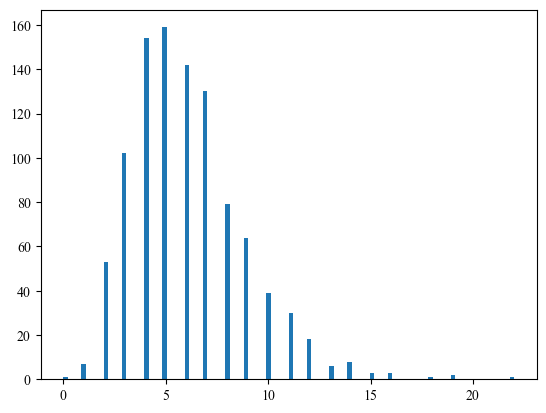

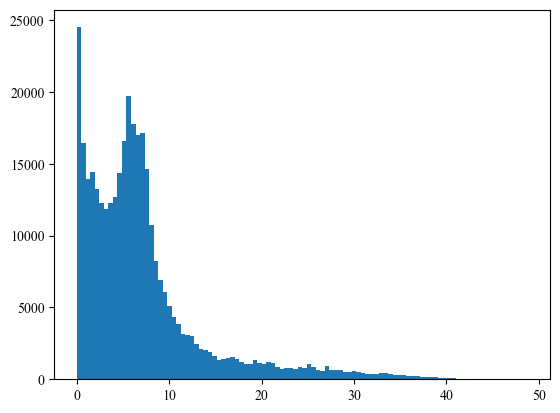

In [114]:
# freeflow
plt.hist(vehicle_nums,bins = 100)
plt.show()
# flatten all items in the speed list
vehicle_speed = np.concatenate(vehicle_speed)
plt.hist(vehicle_speed,bins = 100)
plt.show()

In [20]:
# times new roman font
plt.rcParams['font.family'] = 'Times New Roman'

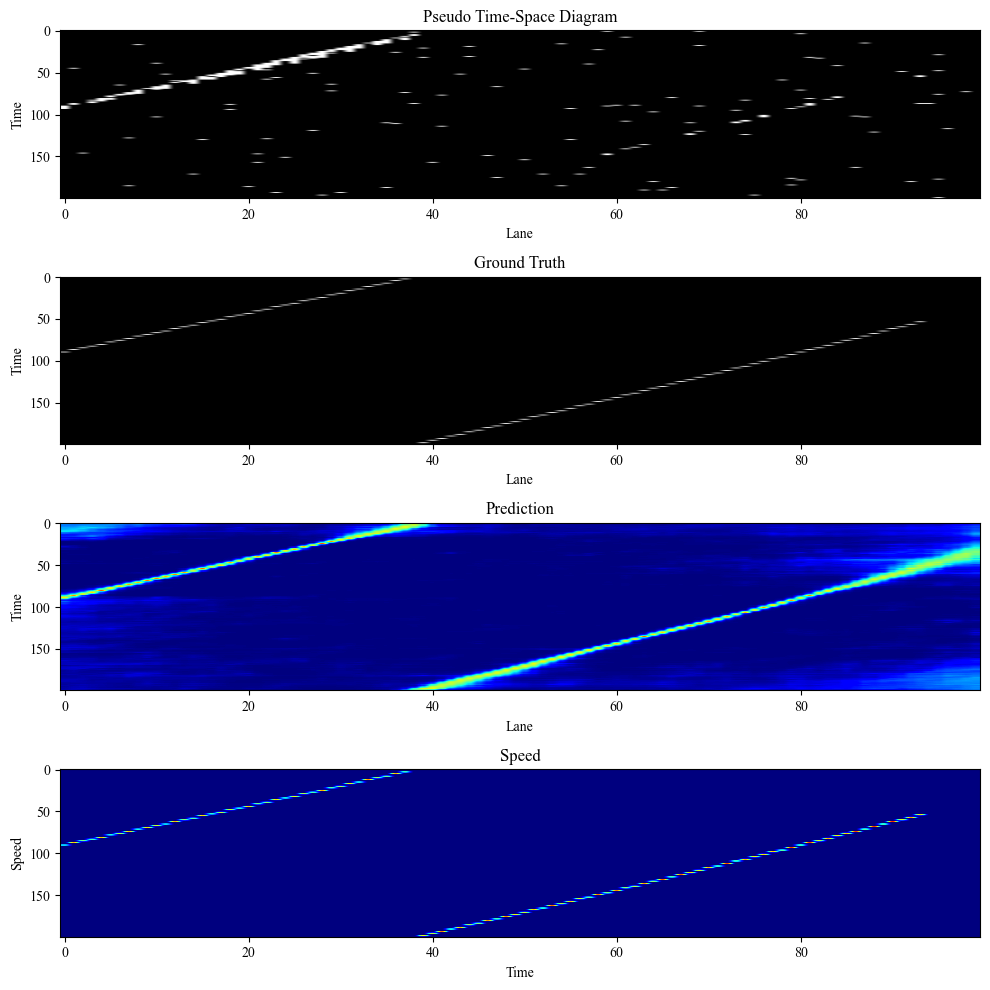

In [79]:
data = val_dataset[3]
post_occ_X = data['post_occ_X']
target = data['target']
speed = data['speed_target']
traj_id = data['traj_id']
# make traj_id upside down
traj_id = np.flipud(traj_id)

output = best_model(post_occ_X.unsqueeze(0).to(device))
numpy_ouput = output.squeeze(0).detach().cpu().numpy()
# post_occ_X.shape
post_occ_X = post_occ_X.squeeze(0).detach().cpu().numpy()

fig, axs = plt.subplots(4, 1, figsize=(10, 10))

# Pseudo Time-Space Diagram
axs[0].imshow(post_occ_X, cmap='gray', aspect='auto')
axs[0].set_title('Pseudo Time-Space Diagram')
axs[0].set_xlabel('Lane')
axs[0].set_ylabel('Time')

# Ground Truth
axs[1].imshow(target, cmap='gray', aspect='auto')
axs[1].set_title('Ground Truth')
axs[1].set_xlabel('Lane')
axs[1].set_ylabel('Time')

# Prediction
axs[2].imshow(numpy_ouput, cmap='jet', aspect='auto')
axs[2].set_title('Prediction')
axs[2].set_xlabel('Lane')
axs[2].set_ylabel('Time')

# Speed
axs[3].imshow(speed.cpu().numpy(), cmap='jet', aspect='auto')
axs[3].set_title('Speed')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Speed')

plt.tight_layout()
plt.show()


In [72]:
from collections import defaultdict

In [73]:
db = Raster_DBSCAN(Td_map_szie=(lane_unit,time_span), window_size=[3,13],eps = 1,min_samples=3)

In [13]:
pred_trajectories = numpy_ouput > 0.35
Labels = db.fit_predict(pred_trajectories, pred_trajectories)
num_lane_units, time_span = numpy_ouput.shape
# Create a dictionary to store the (x,t) profiles for each label
trajectories_output = defaultdict(list)
for t in range(time_span):
    Labels_t = Labels[:,t]
    unique_id, xs, counts = np.unique(Labels_t,return_index=True,return_counts=True)
    center_locations = xs + counts / 2
    if unique_id[0] == -1:
        unique_id = unique_id[1:]
        center_locations = center_locations[1:]
    for i, label in enumerate(unique_id):
        trajectories_output[label].append((t,center_locations[i]))
# calculate speed for each trajectory
speed_output = []
for traj in trajectories_output.values():
    t, x = zip(*traj)
    t = np.array(t)
    x = np.array(x)
    speed = -np.diff(x) * 0.5 / (0.1 * np.diff(t))
    speed_output.append(speed)
trajectories_label = defaultdict(list)
# extract from speed and trajecotry id using same method
for t in range(time_span):
    Labels_t = Labels[:,t]
    unique_id, xs, counts = np.unique(Labels_t,return_index=True,return_counts=True)
    center_locations = xs
    # extract speed
    if unique_id[0] == -1:
        unique_id = unique_id[1:]
        center_locations = center_locations[1:]
    for i, label in enumerate(unique_id):
        trajectories_label[label].append((t,center_locations[i]))
speed_label = []
for traj in trajectories_label.values():
    t, x = zip(*traj)
    t = np.array(t)
    x = np.array(x)
    speed = -np.diff(x) * 0.5 / (0.1 * np.diff(t))
    speed_label.append(speed)


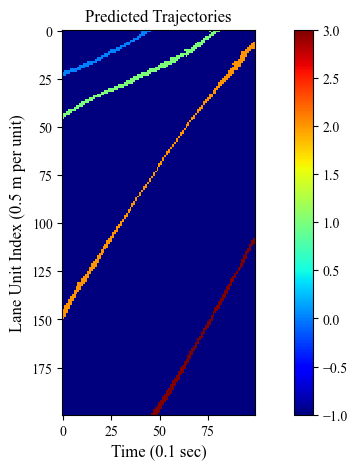

In [18]:
plt.figure(figsize=(10, 5))
plt.imshow(Labels, cmap='jet', interpolation='none')
plt.title('Predicted Trajectories', fontsize=12)
plt.xlabel('Time (0.1 sec)', fontsize=12)
plt.ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
plt.colorbar()
plt.show()


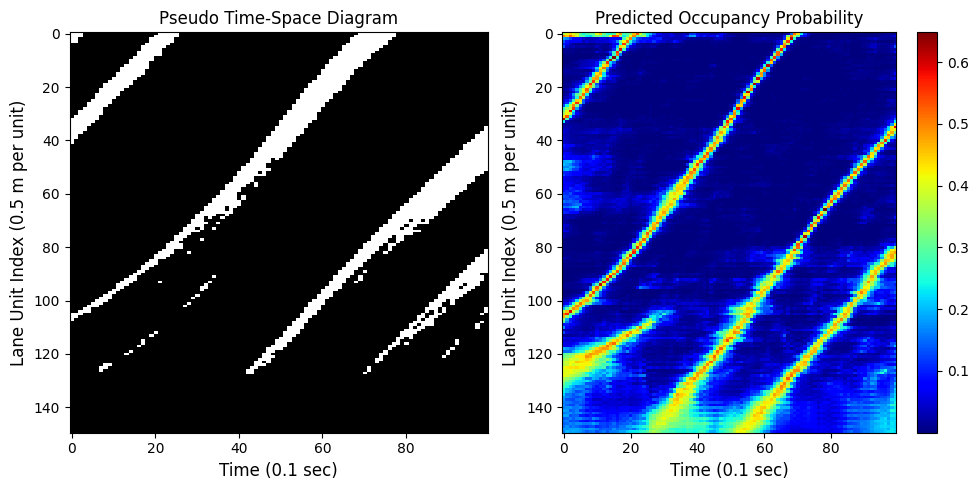

In [7]:
lane_unit_num = 200
test_diagram = np.load(r"D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\lane_2.npy")
# make it upside down
test_diagram = np.flipud(test_diagram)
# pad zeros to make it 200 x-1
original_shape = test_diagram.shape
padding = np.zeros((lane_unit_num - test_diagram.shape[0], test_diagram.shape[1]))
test_diagram = np.concatenate((test_diagram,padding), axis=0)

start_frame = 103

end_frame = start_frame + time_span
test_snippet = test_diagram[:,start_frame:end_frame]
with torch.no_grad():
    input_snippet = torch.from_numpy(test_snippet).float().to(device)
    input_snippet = input_snippet.unsqueeze(0)
    output = best_model(input_snippet)
    output = output.squeeze(0).cpu().numpy()
# only within 100 units are trustable
output = output[:150]
test_snippet = test_snippet[:150]
# plot input_snippet and output
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(test_snippet, cmap='gray',aspect='auto', interpolation='none')
axs[0].set_title('Pseudo Time-Space Diagram', fontsize=12)
axs[0].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[0].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[1].imshow(output, cmap='jet',aspect='auto', interpolation='none')
axs[1].set_title('Predicted Occupancy Probability', fontsize=12)
axs[1].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[1].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
fig.colorbar(axs[1].images[0], ax=axs[1])
plt.tight_layout()
plt.show()


In [10]:
lane_unit_num = 200
test_diagram = np.load(r"D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\lane_2.npy")
# make it upside down
test_diagram = np.flipud(test_diagram)
# pad zeros to make it 200 x-1
original_shape = test_diagram.shape
padding = np.zeros((lane_unit_num - test_diagram.shape[0], test_diagram.shape[1]))
test_diagram = np.concatenate((test_diagram,padding), axis=0)
stride = 30
thred = 0.33
systhesis_diagram = np.zeros_like(test_diagram,dtype = np.float32)
for start_frame in tqdm(range(0, test_diagram.shape[1] - time_span,5)):
    end_frame = start_frame + time_span
    
    test_snippet = test_diagram[:,start_frame:end_frame]
    with torch.no_grad():
        input_snippet = torch.from_numpy(test_snippet).float().to(device)
        input_snippet = input_snippet.unsqueeze(0)
        output = best_model(input_snippet)
        output = output.squeeze(0).cpu().numpy()
    
        systhesis_diagram[:,start_frame:end_frame] += output
thred = 10
db = Raster_DBSCAN(Td_map_szie=systhesis_diagram.shape, window_size=[3,13],eps = 1,min_samples=1)
Labels = db.fit_predict(systhesis_diagram > thred,Foreground_map=systhesis_diagram > thred)
# plot Labels, systhesis_diagram, test_diagram, pred binary diagram in subplots (2,2)
start_frame = 800
end_frame = start_frame + 500
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].imshow(Labels, cmap=colormap, interpolation='none',aspect='auto')
axs[0,0].set_title('Predicted Trajectories', fontsize=12)
axs[0,0].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[0,0].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[0,0].set_xlim([start_frame,end_frame])
axs[0,1].imshow(systhesis_diagram, cmap='jet', interpolation='none',aspect='auto')
axs[0,1].set_title('Predicted Occupancy Probability', fontsize=12)
axs[0,1].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[0,1].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[0,1].set_xlim([start_frame,end_frame])
axs[1,0].imshow(test_diagram, cmap='gray', interpolation='none',aspect='auto')
axs[1,0].set_title('True Occupancy Probability', fontsize=12)
axs[1,0].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[1,0].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[1,0].set_xlim([start_frame,end_frame])
axs[1,1].imshow(systhesis_diagram > thred, cmap='gray', interpolation='none',aspect='auto')
axs[1,1].set_title('Predicted Binary Diagram', fontsize=12)
axs[1,1].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[1,1].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[1,1].set_xlim([start_frame,end_frame])
plt.tight_layout()
# plt.savefig(r"D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\check10.png",dpi = 300)
plt.show()

100%|██████████| 3578/3578 [00:13<00:00, 257.16it/s]


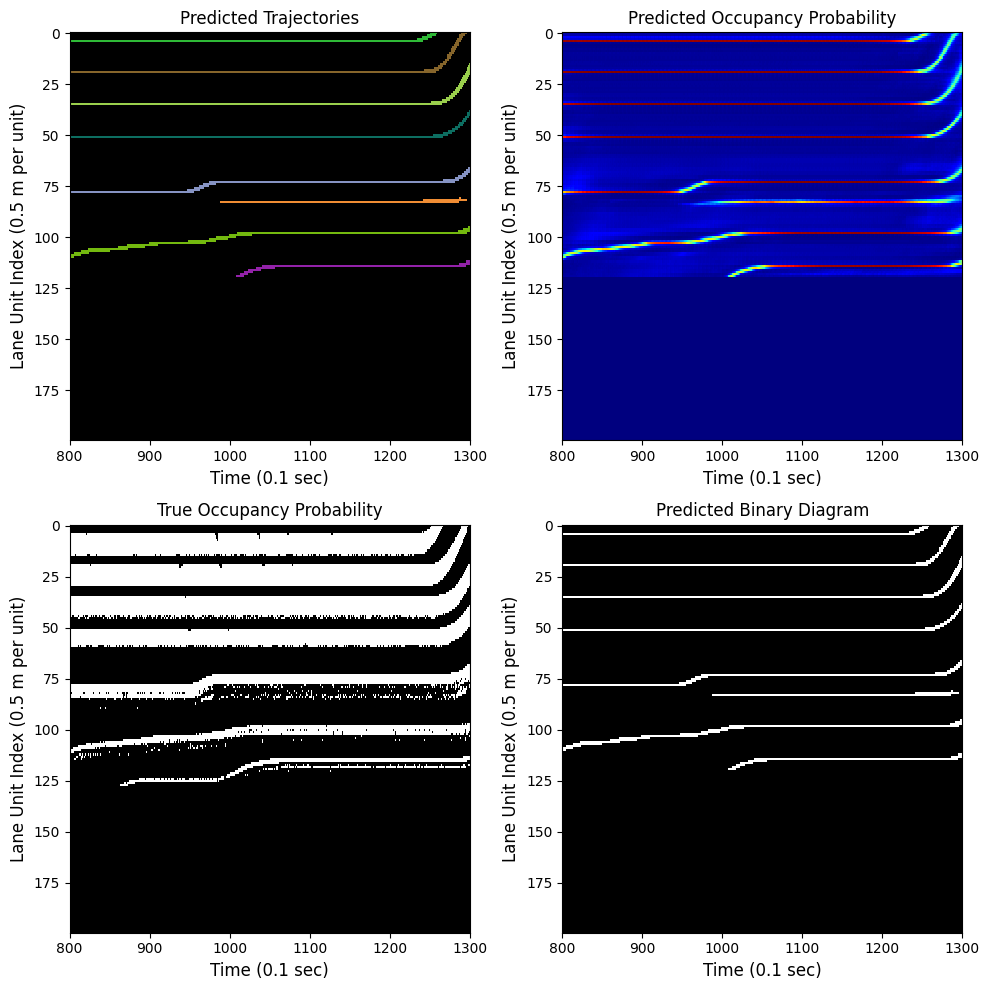

In [19]:
# plot Labels, systhesis_diagram, test_diagram, pred binary diagram in subplots (2,2)
start_frame = 800
end_frame = start_frame + 500
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].imshow(Labels, cmap=colormap, interpolation='none',aspect='auto')
axs[0,0].set_title('Predicted Trajectories', fontsize=12)
axs[0,0].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[0,0].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[0,0].set_xlim([start_frame,end_frame])
axs[0,1].imshow(systhesis_diagram, cmap='jet', interpolation='none',aspect='auto')
axs[0,1].set_title('Predicted Occupancy Probability', fontsize=12)
axs[0,1].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[0,1].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[0,1].set_xlim([start_frame,end_frame])
axs[1,0].imshow(test_diagram, cmap='gray', interpolation='none',aspect='auto')
axs[1,0].set_title('True Occupancy Probability', fontsize=12)
axs[1,0].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[1,0].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[1,0].set_xlim([start_frame,end_frame])
axs[1,1].imshow(systhesis_diagram > thred, cmap='gray', interpolation='none',aspect='auto')
axs[1,1].set_title('Predicted Binary Diagram', fontsize=12)
axs[1,1].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[1,1].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[1,1].set_xlim([start_frame,end_frame])
plt.tight_layout()
# plt.savefig(r"D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\check10.png",dpi = 300)
plt.show()

In [83]:
lane_unit_num = 200
test_diagram = np.load(r"D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\lane_1.npy")
# make it upside down
test_diagram = np.flipud(test_diagram)
# pad zeros to make it 200 x-1
original_shape = test_diagram.shape
padding = np.zeros((lane_unit_num - test_diagram.shape[0], test_diagram.shape[1]))
test_diagram = np.concatenate((test_diagram,padding), axis=0)
stride = 30
# thred = 0.33
systhesis_diagram = np.zeros_like(test_diagram,dtype = np.float32)
for start_frame in tqdm(range(0, test_diagram.shape[1] - time_span,5)):
    end_frame = start_frame + time_span
    
    test_snippet = test_diagram[:,start_frame:end_frame]
    with torch.no_grad():
        input_snippet = torch.from_numpy(test_snippet).float().to(device)
        input_snippet = input_snippet.unsqueeze(0)
        output = best_model(input_snippet)
        output = output.squeeze(0).cpu().numpy()
        systhesis_diagram[:,start_frame:end_frame] += output

100%|██████████| 3578/3578 [00:13<00:00, 260.54it/s]


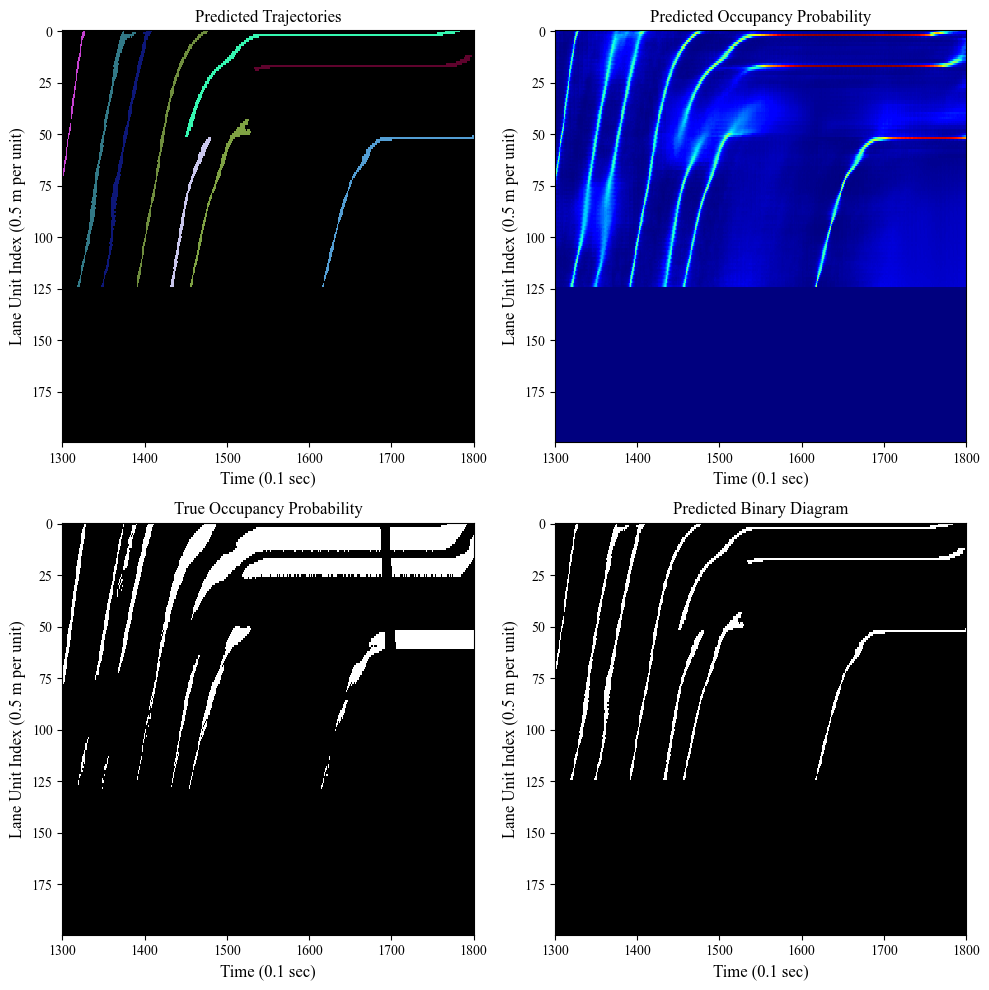

In [88]:
thred = 5
db = Raster_DBSCAN(Td_map_szie=systhesis_diagram.shape, window_size=[5,13],eps = 1,min_samples=1)
systhesis_diagram[125:,:] = 0
Labels = db.fit_predict(systhesis_diagram > thred,Foreground_map=systhesis_diagram > thred)
# plot Labels, systhesis_diagram, test_diagram, pred binary diagram in subplots (2,2)
start_frame = 1300
end_frame = start_frame + 500
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].imshow(Labels, cmap=colormap, interpolation='none',aspect='auto')
axs[0,0].set_title('Predicted Trajectories', fontsize=12)
axs[0,0].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[0,0].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[0,0].set_xlim([start_frame,end_frame])
axs[0,1].imshow(systhesis_diagram, cmap='jet', interpolation='none',aspect='auto')
axs[0,1].set_title('Predicted Occupancy Probability', fontsize=12)
axs[0,1].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[0,1].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[0,1].set_xlim([start_frame,end_frame])
axs[1,0].imshow(test_diagram, cmap='gray', interpolation='none',aspect='auto')
axs[1,0].set_title('True Occupancy Probability', fontsize=12)
axs[1,0].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[1,0].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[1,0].set_xlim([start_frame,end_frame])
axs[1,1].imshow(systhesis_diagram > thred, cmap='gray', interpolation='none',aspect='auto')
axs[1,1].set_title('Predicted Binary Diagram', fontsize=12)
axs[1,1].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[1,1].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[1,1].set_xlim([start_frame,end_frame])
plt.tight_layout()
# plt.savefig(r"D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\check10.png",dpi = 300)
plt.show()

In [95]:
25/2

12.5

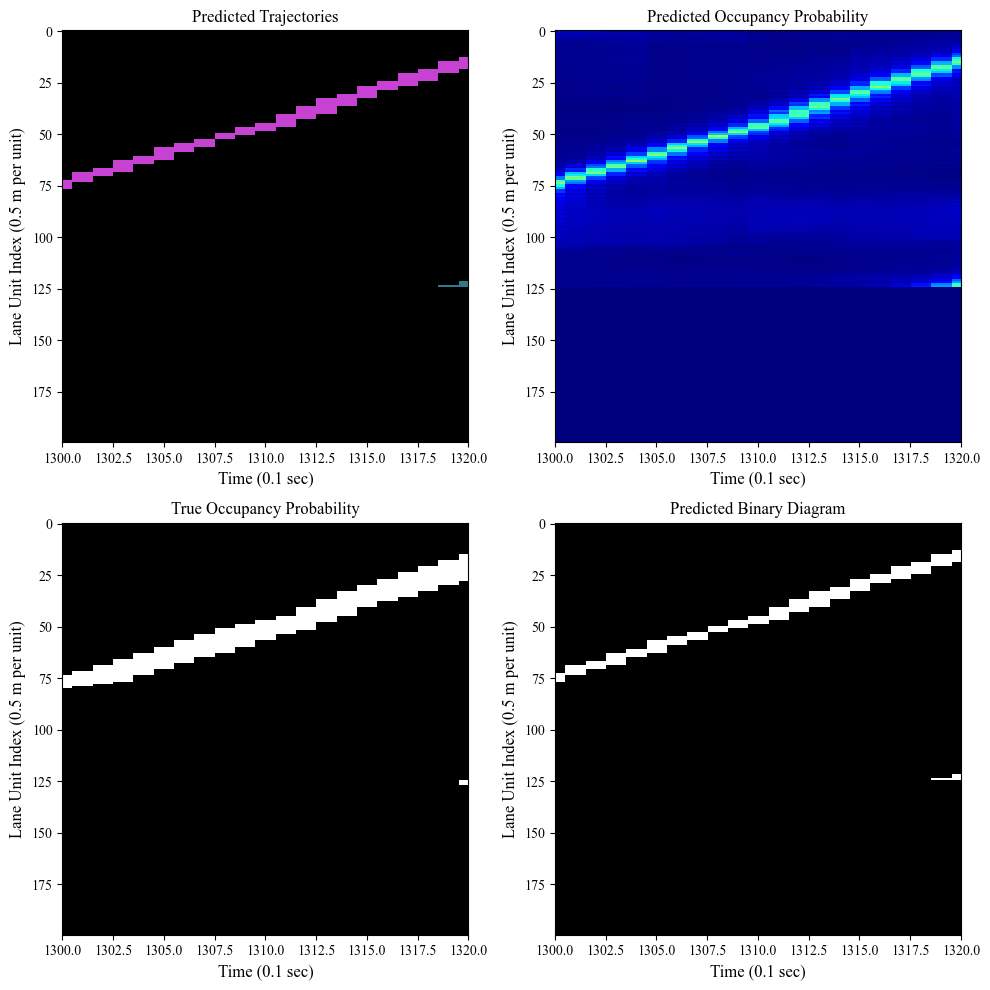

In [94]:
start_frame = 1300
end_frame = start_frame + 20
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].imshow(Labels, cmap=colormap, interpolation='none',aspect='auto')
axs[0,0].set_title('Predicted Trajectories', fontsize=12)
axs[0,0].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[0,0].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[0,0].set_xlim([start_frame,end_frame])
axs[0,1].imshow(systhesis_diagram, cmap='jet', interpolation='none',aspect='auto')
axs[0,1].set_title('Predicted Occupancy Probability', fontsize=12)
axs[0,1].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[0,1].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[0,1].set_xlim([start_frame,end_frame])
axs[1,0].imshow(test_diagram, cmap='gray', interpolation='none',aspect='auto')
axs[1,0].set_title('True Occupancy Probability', fontsize=12)
axs[1,0].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[1,0].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[1,0].set_xlim([start_frame,end_frame])
axs[1,1].imshow(systhesis_diagram > thred, cmap='gray', interpolation='none',aspect='auto')
axs[1,1].set_title('Predicted Binary Diagram', fontsize=12)
axs[1,1].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[1,1].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[1,1].set_xlim([start_frame,end_frame])
plt.tight_layout()
# plt.savefig(r"D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\check10.png",dpi = 300)
plt.show()

In [90]:
from collections import defaultdict

In [91]:
num_lane_units, time_span = systhesis_diagram.shape
# Create a dictionary to store the (x,t) profiles for each label
trajectories_output = defaultdict(list)
for t in range(time_span):
    Labels_t = Labels[:,t]
    unique_id, xs, counts = np.unique(Labels_t,return_index=True,return_counts=True)
    center_locations = xs + counts / 2
    if unique_id[0] == -1:
        unique_id = unique_id[1:]
        center_locations = center_locations[1:]
    for i, label in enumerate(unique_id):
        trajectories_output[label].append((t,center_locations[i]))
# calculate speed for each trajectory
speed_output = []
for traj in trajectories_output.values():
    t, x = zip(*traj)
    t = np.array(t)
    x = np.array(x)
    speed = -np.diff(x) * 0.5 / (0.1 * np.diff(t))
    speed_output.append(speed)
trajectories_label = defaultdict(list)
# extract from speed and trajecotry id using same method
for t in range(time_span):
    Labels_t = Labels[:,t]
    unique_id, xs, counts = np.unique(Labels_t,return_index=True,return_counts=True)
    center_locations = xs
    # extract speed
    if unique_id[0] == -1:
        unique_id = unique_id[1:]
        center_locations = center_locations[1:]
    for i, label in enumerate(unique_id):
        trajectories_label[label].append((t,center_locations[i]))
speed_label = []
for traj in trajectories_label.values():
    t, x = zip(*traj)
    t = np.array(t)
    x = np.array(x)
    speed = -np.diff(x) * 0.5 / (0.1 * np.diff(t))
    speed_label.append(speed)


In [ ]:
import cv2
out_dir = r"D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\ManualImgs"
for i in range(test_diagram.shape[1] - time_span):
    # save to png for manual annotations
    start_frame = i
    end_frame = start_frame + time_span
    test_snippet = test_diagram[:,start_frame:end_frame]
    # save to png as gray scale image
    test_snippet = test_snippet * 255
    test_snippet = test_snippet.astype(np.uint8)
    cv2.imwrite(os.path.join(out_dir,f"{i}.png"),test_snippet)
    
